# Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from scifi.members import BookClubMembers
from scifi.visualizer import (
    create_voting_text,
    rating_to_color,
)

In [2]:
# Read the processed book club data
bookclub_processed_df = pl.read_csv("data/processed_data.csv")

# Get actual member names from the BookClubMembers class
all_member_names = BookClubMembers.get_member_names()

# Only include members who actually have columns in the data
bookclub_members_list = [name for name in all_member_names if name in bookclub_processed_df.columns]

print("Available member columns:", bookclub_members_list)
print("Data shape:", bookclub_processed_df.shape)
print("Sample data:")
print(bookclub_processed_df.select(["title", *bookclub_members_list]).head())

Available member columns: ['Thirsa', 'Koen_v_W', 'Dion', 'Marloes', 'Robert', 'Peter', 'Thomas', 'Koen_M']
Data shape: (73, 20)
Sample data:
shape: (5, 9)
┌────────────────────────────────┬────────┬──────────┬──────┬───┬────────┬───────┬────────┬────────┐
│ title                          ┆ Thirsa ┆ Koen_v_W ┆ Dion ┆ … ┆ Robert ┆ Peter ┆ Thomas ┆ Koen_M │
│ ---                            ┆ ---    ┆ ---      ┆ ---  ┆   ┆ ---    ┆ ---   ┆ ---    ┆ ---    │
│ str                            ┆ f64    ┆ f64      ┆ f64  ┆   ┆ f64    ┆ f64   ┆ f64    ┆ f64    │
╞════════════════════════════════╪════════╪══════════╪══════╪═══╪════════╪═══════╪════════╪════════╡
│ The Road                       ┆ 4.0    ┆ null     ┆ 4.0  ┆ … ┆ 5.0    ┆ null  ┆ null   ┆ null   │
│ Ready Player One (Ready        ┆ 4.0    ┆ 4.0      ┆ 4.0  ┆ … ┆ null   ┆ null  ┆ null   ┆ null   │
│ Player…                        ┆        ┆          ┆      ┆   ┆        ┆       ┆        ┆        │
│ Do Androids Dream of Electric  ┆ 4.

In [ ]:
# Calculate average ratings for each member and create ordered list
# Only include members who have at least one valid rating (numeric and non-zero)
member_averages = []
for member in bookclub_members_list:
    try:
        # Check if column is numeric type and filter for non-null and non-zero ratings
        col_dtype = bookclub_processed_df.select(member).dtypes[0]
        if col_dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
            member_ratings = bookclub_processed_df.filter(
                pl.col(member).is_not_null() & (pl.col(member) != 0)
            ).select(member)

            if len(member_ratings) > 0:  # Only include if member has ratings
                avg_rating = member_ratings.select(pl.col(member).mean()).item()
                if avg_rating is not None:  # Make sure average is valid
                    member_averages.append((member, avg_rating))
                    print(f"{member}: {len(member_ratings)} ratings, avg: {avg_rating:.2f}")
        else:
            print(f"Skipping {member}: non-numeric column type {col_dtype}")
    except Exception as e:  # noqa: BLE001
        print(f"Skipping {member}: {e}")

# Sort by average rating (lowest to highest)
member_averages.sort(key=lambda x: x[1])
ordered_members = [member for member, _ in member_averages]

print(f"\nMembers with valid ratings ({len(ordered_members)}): {ordered_members}")

Thirsa: 41 ratings, avg: 3.39
Koen_v_W: 57 ratings, avg: 3.11
Dion: 59 ratings, avg: 3.60
Marloes: 1 ratings, avg: 4.00
Robert: 64 ratings, avg: 3.41
Peter: 40 ratings, avg: 3.35
Thomas: 29 ratings, avg: 3.83
Koen_M: 8 ratings, avg: 2.50

Members with valid ratings (8): ['Koen_M', 'Koen_v_W', 'Peter', 'Thirsa', 'Robert', 'Dion', 'Thomas', 'Marloes']


In [4]:
selected_book = "Concept M"

book_plot_df = bookclub_processed_df.filter(pl.col("title") == selected_book)

# Only include members who have ratings for this book
members_with_ratings = []
values_with_ratings = []
for member in ordered_members:  # Use only members we know have numeric ratings
    rating = book_plot_df.select(member).to_series().item()
    if rating is not None and rating != 0:
        members_with_ratings.append(member)
        values_with_ratings.append(float(rating))  # Ensure it's a float

# Calculate average rating (excluding None/null values)
avg_rating = float(np.mean(values_with_ratings)) if values_with_ratings else 0.0

fill_color = rating_to_color(avg_rating, alpha=0.3)  # Transparent fill
line_color = rating_to_color(avg_rating, alpha=1.0)  # Opaque line

fig = go.Figure()
fig.add_trace(
    go.Scatterpolar(
        r=values_with_ratings,
        theta=members_with_ratings,
        fill="toself",
        name=selected_book,
        fillcolor=fill_color,
        line={"color": line_color},
    ),
)

fig.update_layout(
    polar={"radialaxis": {"visible": True, "range": [0, 5]}},
    showlegend=False,
    title=f"Ratings for {selected_book} (avg: {avg_rating:.2f}) - {len(members_with_ratings)} members",
)

fig.show()

In [ ]:
# Create a long-form dataframe to plot ratings for each person
# Only include members who have numeric rating columns
long_df = (
    bookclub_processed_df.select(["title", *ordered_members])
    .unpivot(
        index="title",
        on=ordered_members,
        variable_name="Member",
        value_name="Rating",
    )
    .filter((pl.col("Rating").is_not_null()) & (pl.col("Rating") != 0))
)

# Bar plot of ratings per member
fig = px.histogram(
    long_df,
    x="Rating",
    color="Member",
    barmode="group",
    title="Distribution of Book Club Ratings",
    labels={"Rating": "Rating", "Member": "Book Club Member"},
)

fig.show()

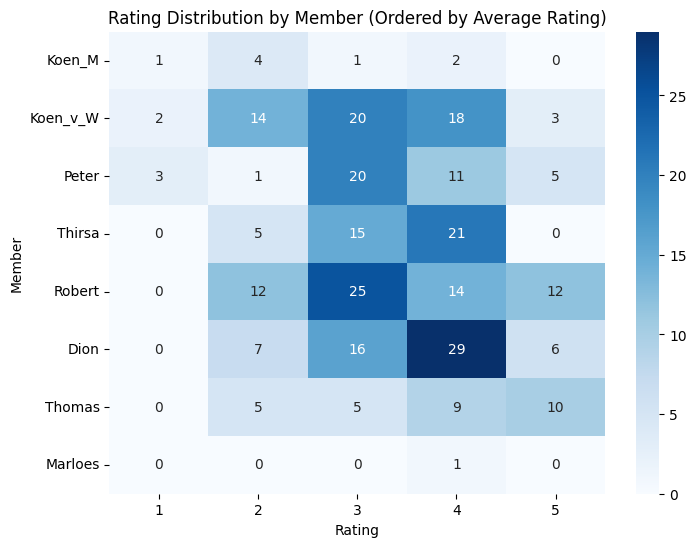

In [6]:
# Create rating distribution data for heatmap
# Only use members who have ratings
rating_matrix = []
for member in ordered_members:
    member_ratings = bookclub_processed_df.filter(
        (pl.col(member) != 0) & (pl.col(member).is_not_null())
    ).select(member)

    # Count ratings for each category (1-5)
    rating_counts = []
    for rating in [1, 2, 3, 4, 5]:
        count = len(member_ratings.filter(pl.col(member) == rating))
        rating_counts.append(count)

    rating_matrix.append(rating_counts)

# Only create heatmap if we have members with ratings
if len(ordered_members) > 0:
    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        rating_matrix,
        xticklabels=[1, 2, 3, 4, 5],
        yticklabels=ordered_members,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
    )

    ax.set_title("Rating Distribution by Member (Ordered by Average Rating)")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Member")

    plt.show()
else:
    print("No members with valid ratings found for heatmap")

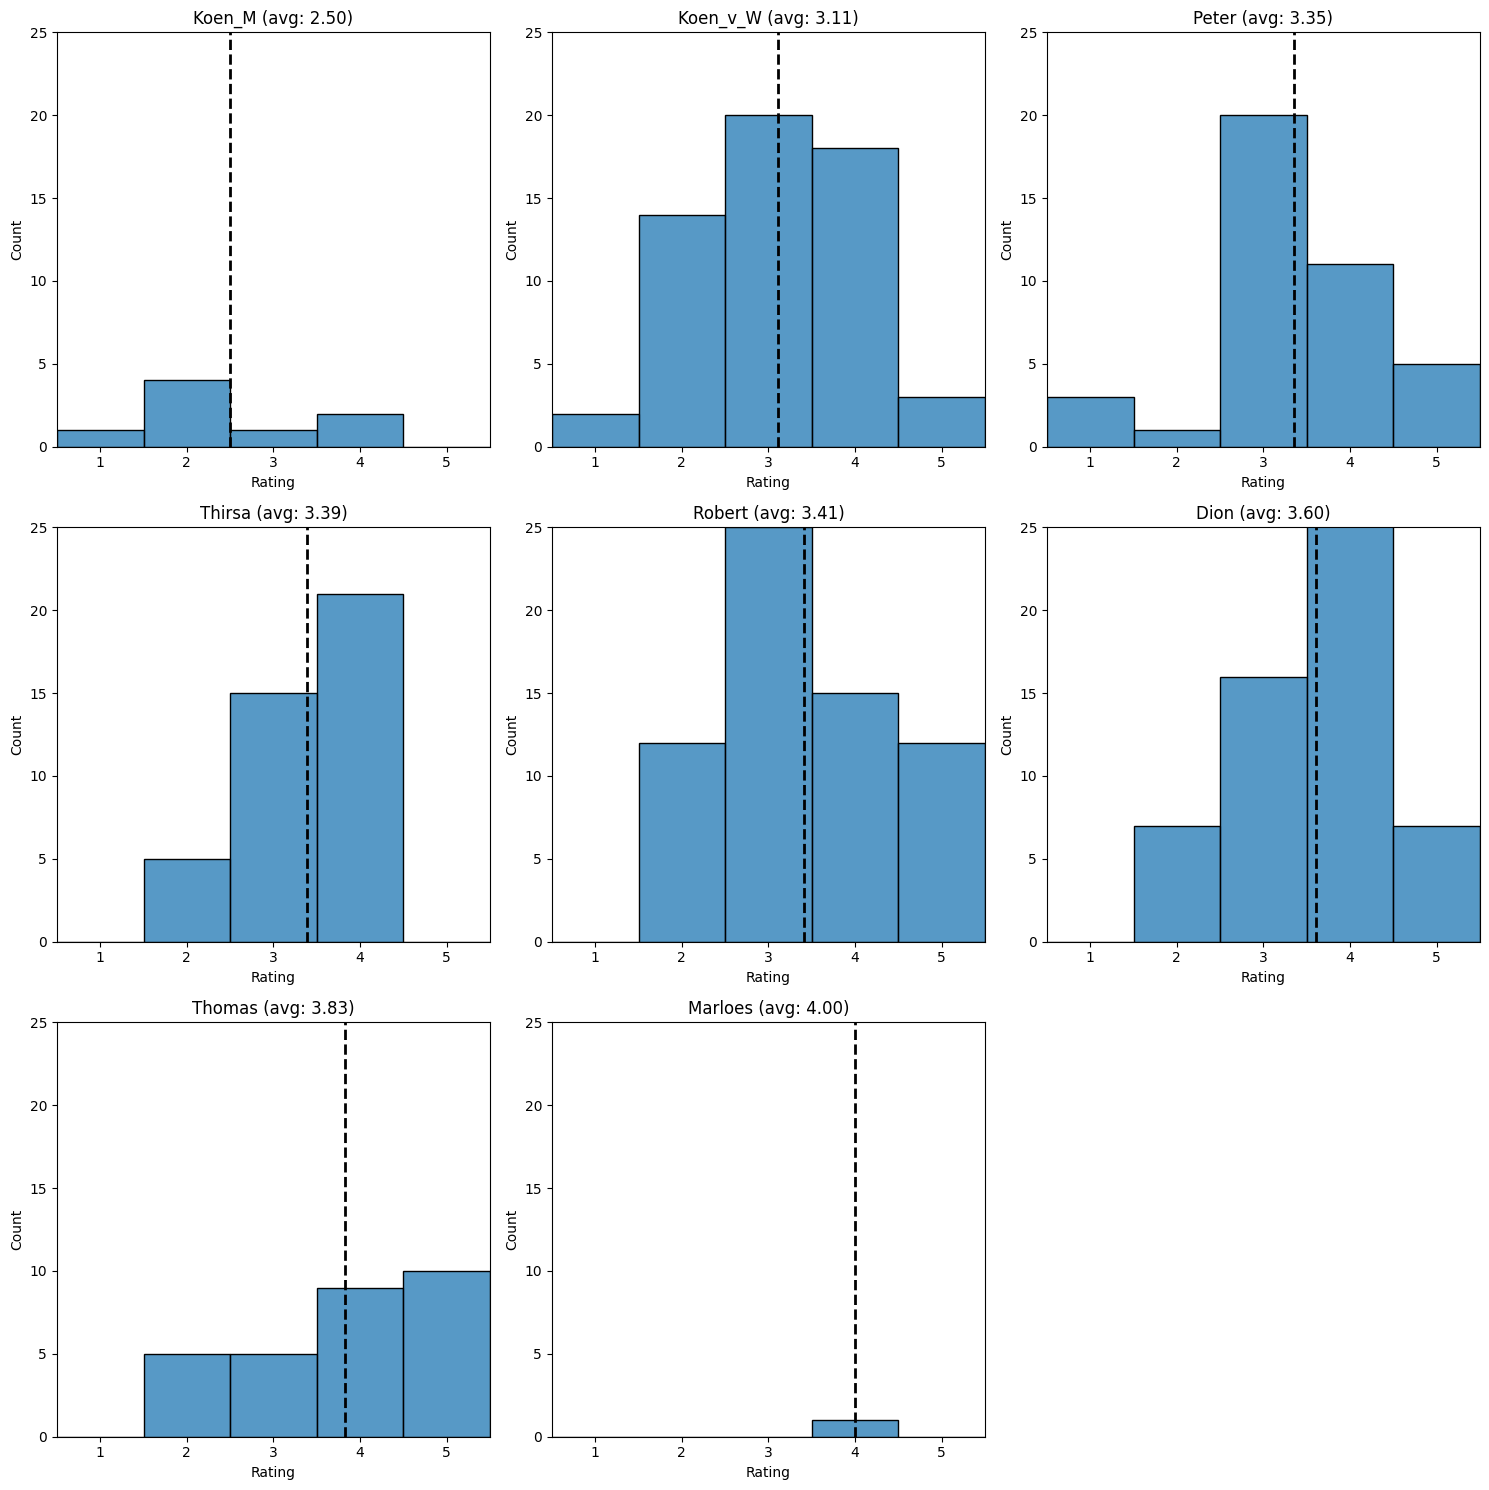

In [7]:
# Create subplot grid - only show members who have ratings
n_members = len(member_averages)

if n_members > 0:
    cols = 3
    rows = (n_members + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    # Define consistent bins for all plots
    bins = np.arange(0.5, 6, 1)  # This creates bins [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

    for i, (member, avg_rating) in enumerate(member_averages):
        # Extract member's ratings
        member_ratings = bookclub_processed_df.filter(
            (pl.col(member) != 0) & (pl.col(member).is_not_null())
        ).select(member)

        # Create histogram for this member
        sns.histplot(
            data=member_ratings,
            x=member,
            bins=bins,  # Use consistent bins
            stat="count",
            ax=axes[i],
        )

        # Set x-axis to show only integers 1-5
        axes[i].set_xticks([1, 2, 3, 4, 5])
        axes[i].set_xlim(0.5, 5.5)

        # Set y-axis to consistent maximum
        axes[i].set_ylim(0, 25)

        # Add average line
        axes[i].axvline(avg_rating, color="black", linestyle="--", linewidth=2)

        # Set title and labels
        axes[i].set_title(f"{member} (avg: {avg_rating:.2f})")
        axes[i].set_xlabel("Rating")
        axes[i].set_ylabel("Count")

    # Hide unused subplots
    for i in range(len(member_averages), len(axes)):
        axes[i].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()
else:
    print("No members with valid ratings found for histogram plots")

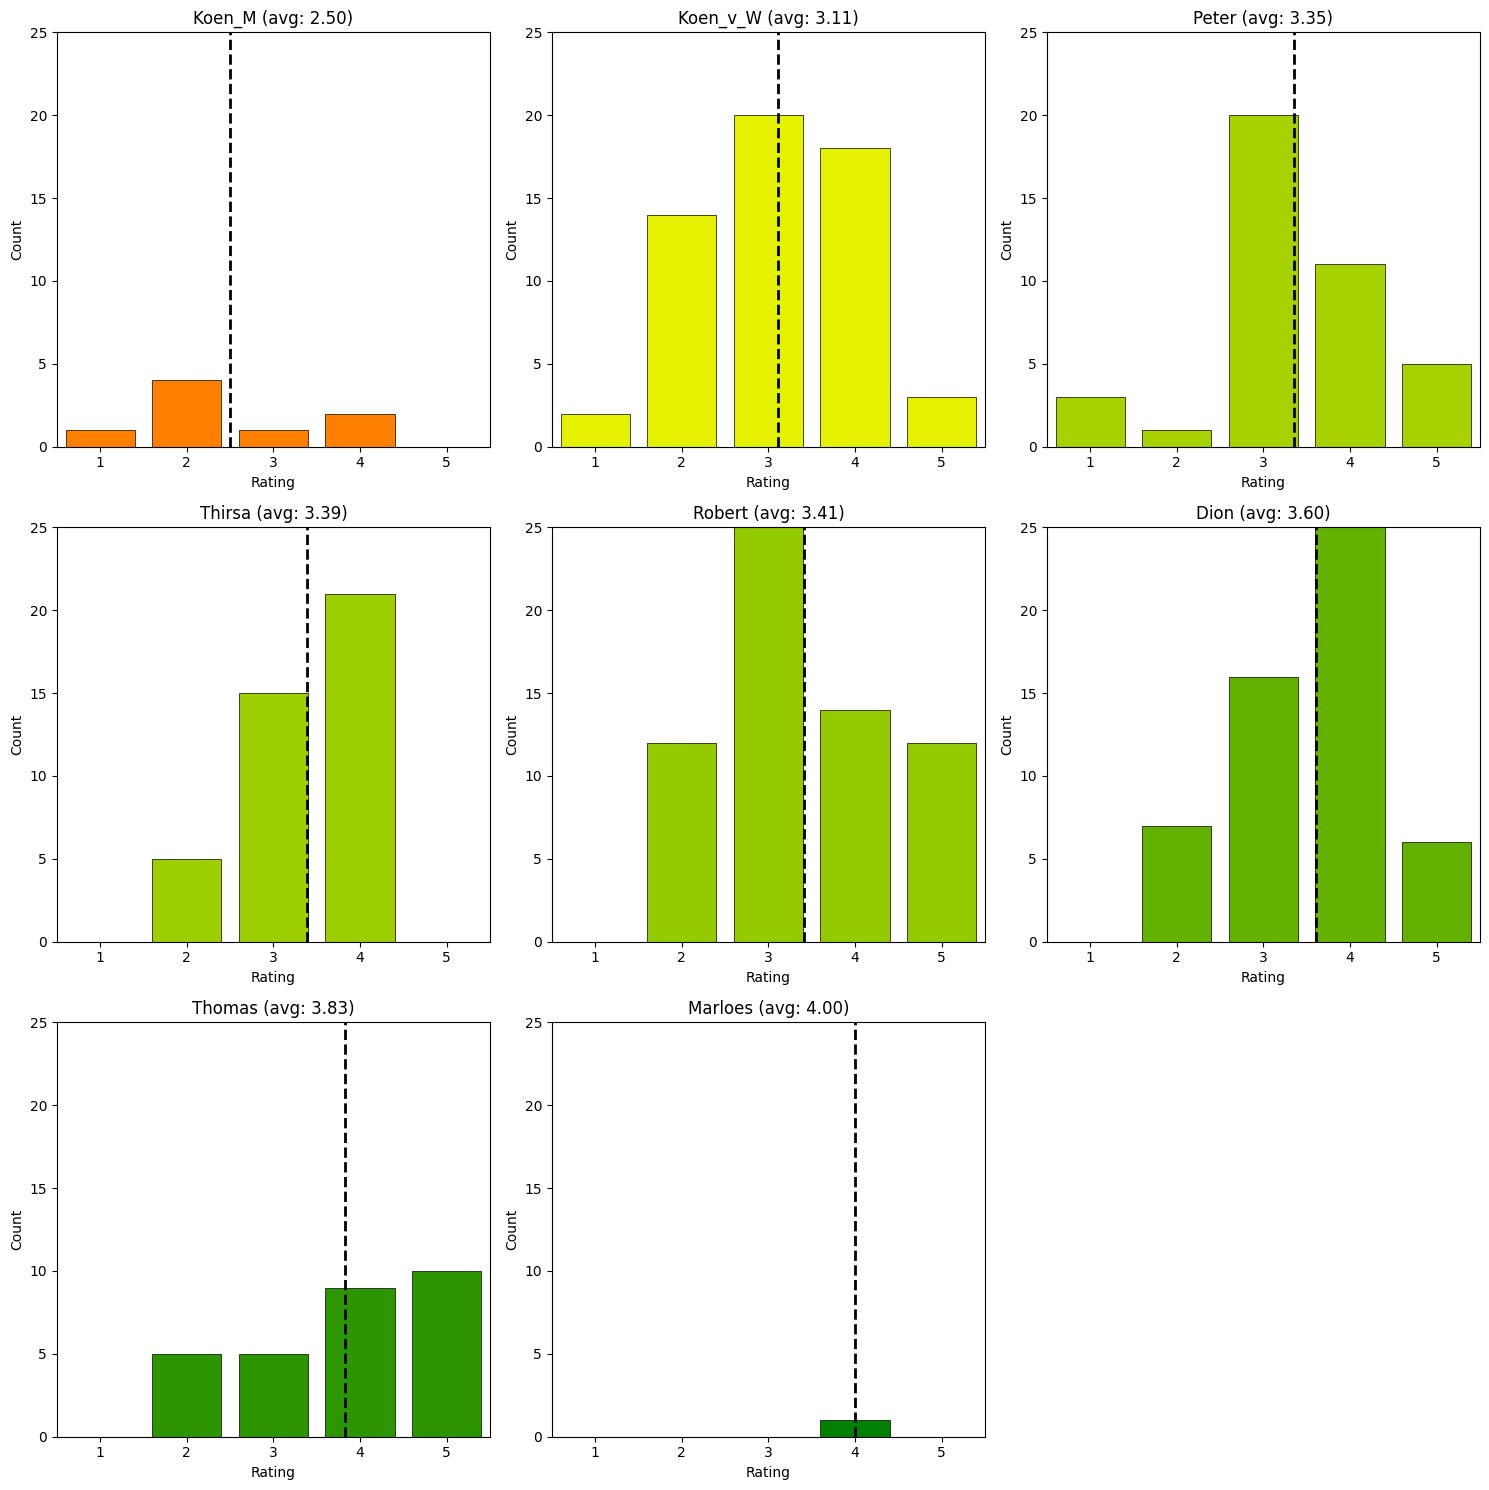

In [8]:
# Create color map from red to green
cmap = LinearSegmentedColormap.from_list("red_to_green", ["red", "yellow", "green"])

# Create subplot grid for members with ratings
n_members = len(member_averages)

if n_members > 0:
    cols = 3
    rows = (n_members + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i, (member, avg_rating) in enumerate(member_averages):
        # Map average rating to color (2=red, 4=green)
        color_value = (avg_rating - 2) / 2  # Normalize 2-4 range to 0-1
        color_value = np.clip(color_value, 0, 1)  # Clamp to 0-1 range
        member_color = cmap(color_value)

        # Extract member's ratings
        member_ratings = bookclub_processed_df.filter(
            (pl.col(member) != 0) & (pl.col(member).is_not_null())
        ).select(member)

        # Calculate histogram counts for each rating
        rating_counts = []
        for rating in [1, 2, 3, 4, 5]:
            count = len(member_ratings.filter(pl.col(member) == rating))
            rating_counts.append(count)

        # Create bar plot with member's color
        bars = axes[i].bar(
            [1, 2, 3, 4, 5],
            rating_counts,
            color=member_color,
            width=0.8,
            edgecolor="black",
            linewidth=0.5,
        )

        # Set x-axis and y-axis
        axes[i].set_xticks([1, 2, 3, 4, 5])
        axes[i].set_xlim(0.5, 5.5)
        axes[i].set_ylim(0, 25)

        # Add average line
        axes[i].axvline(avg_rating, color="black", linestyle="--", linewidth=2)

        # Set title and labels
        axes[i].set_title(f"{member} (avg: {avg_rating:.2f})")
        axes[i].set_xlabel("Rating")
        axes[i].set_ylabel("Count")

    # Hide unused subplots
    for i in range(len(member_averages), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No members with valid ratings found for colored bar plots")

In [9]:
plot_df = bookclub_processed_df.with_columns(
    [pl.col("original_publication_year").cast(pl.Int32).alias("year")],
)
df_plot = plot_df.sort("year")

# Add the voting members column using map_rows
# Only use members who actually exist in the data and have numeric ratings
df_with_voting = df_plot.with_columns(
    pl.struct(ordered_members)
    .map_elements(lambda row: create_voting_text(ordered_members, row), return_dtype=pl.Utf8)
    .alias("voting_members"),
)

fig = px.line(
    df_with_voting,
    x="year",
    y="average_bookclub_rating",
    title="Our Rating per Publication Year",
    labels={"year": "Publication Year", "average_bookclub_rating": "Average Rating"},
    markers=True,
)

# Update hover template for bookclub rating
fig.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><br>"
    "Author: %{customdata[1]}<br>"
    "Year: %{x}<br>"
    "Bookclub Rating: %{y:.2f}<br>"
    "%{customdata[2]}<extra></extra>",
    customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
)

# Add Goodreads rating as a dashed red line
fig.add_trace(
    go.Scatter(
        x=df_with_voting["year"],
        y=df_with_voting["average_goodreads_rating"],
        mode="lines+markers",
        name="Goodreads Rating",
        line={"color": "red", "dash": "dash"},
        customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
        hovertemplate="<b>%{customdata[0]}</b><br>"
        "Author: %{customdata[1]}<br>"
        "Year: %{x}<br>"
        "Goodreads Rating: %{y:.2f}<br>"
        "%{customdata[2]}<extra></extra>",
    ),
)

# Update y-axis label to be more generic
fig.update_layout(yaxis_title="Average Rating")

fig.show()

In [10]:
# Sort the dataframe by date
plot_df = bookclub_processed_df.sort("date")

# Add the voting members column using map_rows (same as first figure)
# Only use members who actually exist in the data and have numeric ratings
df_with_voting = plot_df.with_columns(
    pl.struct(ordered_members)
    .map_elements(lambda row: create_voting_text(ordered_members, row), return_dtype=pl.Utf8)
    .alias("voting_members"),
)

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for the rating over time, with enhanced hover information
fig.add_trace(
    go.Scatter(
        x=df_with_voting["date"],
        y=df_with_voting["average_bookclub_rating"],
        mode="lines+markers",
        name="Bookclub Rating",
        customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
        hovertemplate="<b>%{customdata[0]}</b><br>"
        "Author: %{customdata[1]}<br>"
        "Date: %{x|%Y-%m-%d}<br>"
        "Bookclub Rating: %{y:.2f}<br>"
        "%{customdata[2]}<extra></extra>",
    ),
)

# Add a line trace for the average Goodreads rating over time
fig.add_trace(
    go.Scatter(
        x=df_with_voting["date"],
        y=df_with_voting["average_goodreads_rating"],
        mode="lines+markers",
        name="Goodreads Rating",
        customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
        hovertemplate="<b>%{customdata[0]}</b><br>"
        "Author: %{customdata[1]}<br>"
        "Date: %{x|%Y-%m-%d}<br>"
        "Goodreads Rating: %{y:.2f}<br>"
        "%{customdata[2]}<extra></extra>",
        line={"dash": "dash"},  # Optionally make the Goodreads rating line dashed
    ),
)

# Set the title and labels for axes
fig.update_layout(
    title="Rating Over Time",
    xaxis_title="Date",
    yaxis_title="Rating",
    template="plotly_white",
)

# Show the interactive plot
fig.show()